# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [17]:
# import libraries
import re
import joblib
import pandas as pd
from sqlalchemy import create_engine

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, precision_recall_fscore_support

# for word cloud test
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [18]:
# load data from database
engine = create_engine('sqlite:///data/DisasterResponse.db')
df = pd.read_sql_table('disaster_messages', con=engine)
X_labels = ['id', 'message', 'original', 'genre']
X = df[X_labels]
Y = df.drop(columns=X_labels)

In [19]:
X.head(1)

,id,message,original,genre
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct


In [20]:
Y.head(1)

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
Y['related'].value_counts()

1    19876
0     6304
Name: related, dtype: int64

### 2. Write a tokenization function to process your text data

In [22]:
def tokenize(text):
    lemmatizer = WordNetLemmatizer()
    
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text.lower())
    
    token_list = word_tokenize(text)
    token_list = [token.strip() for token in token_list if token not in stopwords.words("english")]
    token_list = [lemmatizer.lemmatize(token) for token in token_list]
        
    return token_list

In [23]:
tokenize(X.message[7])

['please', 'need', 'tent', 'water', 'silo', 'thank']

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [24]:
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultiOutputClassifier(RandomForestClassifier(
        max_features=0.1,
        min_samples_split=2,
        n_estimators=50
    )))],
    verbose=True
)

In [8]:
pipeline.get_params()

{'memory': None,
 'steps': [('vectorizer',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                   lowercase=True, max_df=1.0, max_features=None, min_df=1,
                   ngram_range=(1, 1), preprocessor=None, stop_words=None,
                   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=<function tokenize at 0x000001BC08CDB158>,
                   vocabulary=None)),
  ('tfidf',
   TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
  ('classifier',
   MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                          class_weight=None,
                                                          criterion='gini',
                                                          max_depth=None,
                                                    

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X['message'], Y)

In [26]:
X_test.shape

(6545,)

In [27]:
pipeline.fit(X_train, Y_train);

[Pipeline] ........ (step 1 of 3) Processing vectorizer, total= 1.1min
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=13.4min


### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [29]:
Y_pred = pipeline.predict(X_test)

In [33]:
print(classification_report(Y_test, Y_pred, target_names=Y_test.columns))

                        precision    recall  f1-score   support

               related       0.86      0.90      0.88      4961
               request       0.77      0.55      0.64      1151
                 offer       0.00      0.00      0.00        17
           aid_related       0.73      0.70      0.71      2717
          medical_help       0.51      0.27      0.35       564
      medical_products       0.62      0.34      0.44       340
     search_and_rescue       0.54      0.25      0.35       173
              security       0.09      0.01      0.03       136
              military       0.60      0.33      0.43       237
           child_alone       0.00      0.00      0.00         0
                 water       0.69      0.73      0.71       400
                  food       0.81      0.77      0.79       723
               shelter       0.76      0.60      0.67       583
              clothing       0.66      0.58      0.62        98
                 money       0.59      

In [37]:
def evaluate_model(model, X_test, Y_test):
    Y_pred = model.predict(X_test)
    accuracy = (Y_pred == Y_test).mean().mean()
    report = classification_report(Y_test, Y_pred, target_names=Y_test.columns)
    print('='*70)
    print('[INFO] - Classification Report:')
    print('-'*70)
    print(report)
    print('-'*70)
    print('[INFO] - Overall accuracy: {:.2f}%'.format(accuracy*100))
    print('='*30 + ' END REPORTS ' + '='*30)

In [38]:
evaluate_model(pipeline, X_test, Y_test)

[INFO] - Classification Report:
----------------------------------------------------------------------
                        precision    recall  f1-score   support

               related       0.86      0.90      0.88      4961
               request       0.77      0.55      0.64      1151
                 offer       0.00      0.00      0.00        17
           aid_related       0.73      0.70      0.71      2717
          medical_help       0.51      0.27      0.35       564
      medical_products       0.62      0.34      0.44       340
     search_and_rescue       0.54      0.25      0.35       173
              security       0.09      0.01      0.03       136
              military       0.60      0.33      0.43       237
           child_alone       0.00      0.00      0.00         0
                 water       0.69      0.73      0.71       400
                  food       0.81      0.77      0.79       723
               shelter       0.76      0.60      0.67       583


### 6. Improve your model
Use grid search to find better parameters. 

In [20]:
parameters = {
    'classifier__estimator__n_estimators': [10, 25, 50],
    'classifier__estimator__min_samples_split': [2,4,6],
    'classifier__estimator__max_features': [.1, .25, .5, 'sqrt', 'log2']
}

cv = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=3)

In [21]:
cv.fit(X_train, Y_train)

Fitting 3 folds for each of 45 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 101.1min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 703.0min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 741.3min finished


[Pipeline] ........ (step 1 of 3) Processing vectorizer, total= 4.0min
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=15.0min


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                 

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [22]:
pd.DataFrame(cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__estimator__max_features,param_classifier__estimator__min_samples_split,param_classifier__estimator__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,495.196485,2.519397,147.554188,1.713290,0.1,2,10,"{'classifier__estimator__max_features': 0.1, '...",0.254698,0.267838,0.266769,0.263102,0.005958,20
1,830.910966,52.967946,148.520633,1.841346,0.1,2,25,"{'classifier__estimator__max_features': 0.1, '...",0.264018,0.271658,0.279144,0.271607,0.006175,12
2,1333.966658,28.573162,153.579571,1.710992,0.1,2,50,"{'classifier__estimator__max_features': 0.1, '...",0.275630,0.281436,0.282964,0.280010,0.003159,1
3,486.393711,9.149642,145.635952,1.490548,0.1,4,10,"{'classifier__estimator__max_features': 0.1, '...",0.249809,0.271199,0.261727,0.260912,0.008752,22
4,796.908459,10.614006,148.361388,1.809247,0.1,4,25,"{'classifier__estimator__max_features': 0.1, '...",0.265241,0.278380,0.277158,0.273593,0.005927,11
5,1289.159445,4.271427,157.815626,6.035836,0.1,4,50,"{'classifier__estimator__max_features': 0.1, '...",0.267074,0.285256,0.283422,0.278584,0.008173,3
6,484.836922,20.462418,145.896134,5.294757,0.1,6,10,"{'classifier__estimator__max_features': 0.1, '...",0.249351,0.259740,0.269519,0.259537,0.008235,26
7,770.243870,10.863134,148.126542,2.506219,0.1,6,25,"{'classifier__estimator__max_features': 0.1, '...",0.266616,0.281283,0.277769,0.275223,0.006253,6
8,1259.073857,15.358330,152.179540,2.069410,0.1,6,50,"{'classifier__estimator__max_features': 0.1, '...",0.272880,0.284492,0.281283,0.279552,0.004896,2
9,753.371016,31.074915,146.082693,1.403461,0.25,2,10,"{'classifier__estimator__max_features': 0.25, ...",0.255921,0.267991,0.259893,0.261268,0.005023,21


In [23]:
cv.best_estimator_

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function toke...
                 MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                                        class_weight=None,
                                                                        criterion='gini',
                                                                   

In [24]:
cv.best_params_

{'classifier__estimator__max_features': 0.1,
 'classifier__estimator__min_samples_split': 2,
 'classifier__estimator__n_estimators': 50}

In [26]:
evaluate_model(cv, X_test, Y_test)

Label: related
--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00         3

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36

Label: request
--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36

Label: offer
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        33
           1       1.00      0.33      0.50         3

    accuracy                           0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### 9. Export your model as a pickle file

In [28]:
file_name = 'classifier.pkl'
joblib.dump(cv.best_estimator_, file_name)

['classifier.pkl']

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.

### 11. Try out some data extracting for the plotly visualisations

Going to test how to extract the data, I want to visualize on the app starting page here.

In [8]:
model = joblib.load('./models/classifier.pkl')

In [14]:
Y.head()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
Y.sum().to_numpy()

array([20252,  4464,   118, 10841,  2081,  1311,   724,   471,   859,
           0,  1669,  2917,  2308,   404,   603,   298,   874,  1192,
        3441,  1705,  1199,  1331,   532,   159,   283,   120,   309,
        1151,  7286,  2149,  2440,   282,  2452,   528,  1376,  5064])

In [21]:
label_count = {
    'label_list': Y.columns,
    'label_count': Y.sum()
}
#label_count

In [22]:
vectorizer = CountVectorizer(tokenizer=tokenize)

In [24]:
doc_matrix = vectorizer.fit_transform(X['message'])

<26180x31967 sparse matrix of type '<class 'numpy.int64'>'
	with 363064 stored elements in Compressed Sparse Row format>

In [30]:
bag_of_words = pd.DataFrame(doc_matrix.toarray(), columns=vectorizer.get_feature_names())

In [33]:
bag_counts = bag_of_words.sum()

In [34]:
bag_counts.nlargest(20)

water         3037
people        3006
food          2898
help          2651
need          2490
please        2045
earthquake    1918
u             1756
area          1664
like          1527
would         1489
said          1350
http          1256
000           1251
country       1250
also          1114
know          1113
government    1056
haiti         1041
one           1020
dtype: int64

In [57]:
most_common_words = bag_counts.nlargest(100)

In [62]:
wordcloud = WordCloud(background_color="white", width=1920, height=1080)
wordcloud.fit_words(most_common_words)

In [63]:
wordcloud.to_file('app/static/topwords.png')

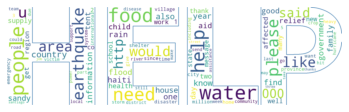

<Figure size 432x288 with 0 Axes>

In [56]:
# taken from 
mask = np.array(Image.open('./app/help.png'))

wc = WordCloud(background_color="white", max_words=2000, mask=mask, contour_width=3, contour_color='steelblue')
wc.fit_words(most_common_words)

# store to file
wc.to_file('topwords_helpmask.png')

# show
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
#plt.imshow(mask.squeeze(), cmap=plt.cm.gray, interpolation='bilinear')
#plt.axis("off")
plt.show()

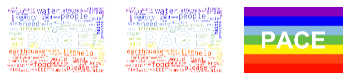

In [55]:
# create coloring from image
image_colors = ImageColorGenerator(mask)

# show
fig, axes = plt.subplots(1, 3)
axes[0].imshow(wc, interpolation="bilinear")
# recolor wordcloud and show
# we could also give color_func=image_colors directly in the constructor
axes[1].imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
axes[2].imshow(mask, cmap=plt.cm.gray, interpolation="bilinear")
for ax in axes:
    ax.set_axis_off()
plt.show()